In [4]:
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
import random
import math
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("./max_dataset.csv")
df = df.fillna("Nil")
df.replace("0", "Nil", inplace=True)
df.replace("Nil", 0, inplace=True)
df.replace("Negative", 0, inplace=True)
df.replace("Normal", 0, inplace=True)
df.replace("Absent", 0, inplace=True)
df.replace("Yes", True, inplace=True)
df.replace("No", False, inplace=True)
df = df.select_dtypes(include=[int, float, bool, object])
df = df.drop(columns=[df.columns[0], df.columns[1]])
df

,PDOB.dob,PGDR.gender,PCHC.chiefcomplains,DAAA.doyouhaveanyallergies?,DAAD.drugallergies,DAAF.fooditemallergies,DAAS.skinallergies,DAAR.respiratoryallergies,DAAO.anyotherallergies,"HLSO.doyoucurrentlysmokeanytobaccoproductsdaily,suchascigarettes,cigarsorpipes?",...,LSTP.trophozoite,LAUB.uibc,LBRU.urea,LBRA.uricacid,LUSF.urinesugarfasting,LUSP.urinesugarpp,LUUB.urobilinogen,LABT.vitaminb12,LBLV.vldlcholesterol,LEEK.whitebloodcell
0,30-Aug-1963,Male,0,True,0,0,Due to summer,0,0,False,...,0,0.0,12.4,5.0,0,0,0,0,15.2,1-2
1,1-Jan-1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,0,0.0,0,0,0,0,0.0,1-2
2,8-Feb-1969,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.4,6.1,0,0,0,0,19.2,0-1
3,7-Aug-1963,Male,Asthma,True,0,0,0,Dust,0,False,...,0,0.0,28.7,5.0,0,0,0,0,16.0,2-4
4,1-Feb-1974,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.0,7.3,0,0,0,0,56.4,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,7-May-1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,21.0,4.2,0,0,0,0,31.4,2-3
2688,6-Feb-1962,Male,0,False,0,0,0,0,0,True,...,0,0.0,22.6,6.3,0,0,0,0,14.4,2-4
2689,31-Oct-1972,Male,0,False,0,0,0,0,0,True,...,0,0.0,31.3,7.6,0,0,0,169,34.4,0-1
2690,25-Jul-1967,Male,0,False,0,0,0,0,0,False,...,0,0.0,24.1,7.5,0,0,0,0,33.2,1-2


In [2]:
def support(r):
    return ((df.iloc[r] != 0) & (df.iloc[r] != False)).sum()

In [3]:
def support_cols(r1):
    return (df.iloc[r1] != 0) & (df.iloc[r1] != False)

In [41]:
def union_support_cols(r1, r2):
    return ((df.iloc[[r1, r2]] != 0) & (df.iloc[[r1, r2]] != False)).any(axis=0)

In [42]:
def union_support(r1, r2):
    return union_support_cols(r1, r2).sum()

In [43]:
def similar(df, r1, r2, c):
    if df[c].dtype != bool and not pd.to_numeric(df[c], errors='coerce').isna().any():
        if df.loc[r1, c] == df.loc[r2, c]:
        # if df.loc[r1, c] - df.loc[r2, c] < (df[c].std() / 5):
            return 1
        else:
            return 0
    elif df[c].dtype == object:
        if df.loc[r1, c] == df.loc[r2, c]:
            return 1
        else:
            return 0
    else:
        return 1 if ((df.loc[r1, c] and df.loc[r2, c]) or not (df.loc[r1, c] and df.loc[r2, c])) else 0

In [44]:
# Sim(r1, r2) as defined by the paper
def compute_similarity(df, r1, r2):
    similarity = 0
    for column in df.loc[:, union_support_cols(r1, r2)].columns:
        similarity += similar(df, r1, r2, column)
    return similarity/union_support(r1, r2)

In [45]:
def match_records(r1, aux_cols):
    return df[df[aux_cols].apply(lambda row: (row == df.loc[r1, aux_cols]).all(), axis=1)]

In [83]:
def match_against_aux(r1, r2):
    supported_features = df.loc[[r1, r2], union_support_cols(r1, r2)]
    aux_col_names = [supported_features.columns[i] for i in [random.randint(0, len(supported_features.columns)) for _ in range(4)]]
    return match_records(r1, aux_col_names), aux_col_names

In [138]:
# Scoreboard-RH from paper
def compute_score(df, r1):
    supported = df.loc[r1, support_cols(r1)]
    print(supported)
    aux = [supported.index[i] for i in [random.randint(0, len(supported)) for _ in range(4)]]
    weight = 1/(math.log(support(r1)))

    df["scores"] = df.apply(lambda row2: (sum(similar(supported, r1, row2, column))) for column in df.loc[:, aux].columns)
    df["scores"] = weight * df["scores"]
    score = df["scores"].max()
    score2 = df["scores"].nlargest(2)

    return score, score2, df["scores"].std()

In [46]:
target_record = 0

In [105]:
tqdm.pandas()
temp = df.iloc[:100]
temp["similarity"] = temp.apply(lambda x: temp.progress_apply(lambda y: compute_similarity(x.name, y.name), axis=1).mean(), axis=1)

100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


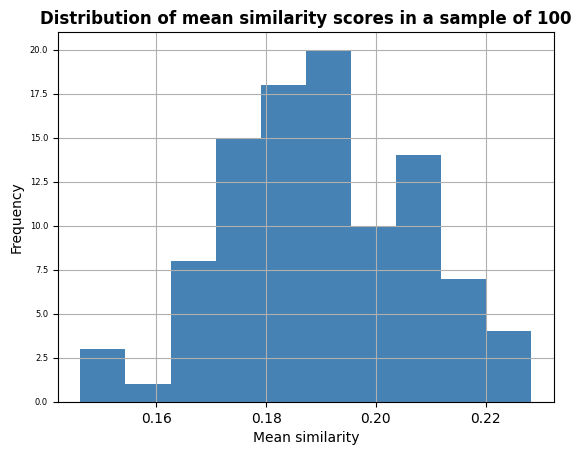

In [112]:
temp["similarity"].max()
ax = temp["similarity"].hist(bins=10, xlabelsize=10, ylabelsize=6, color="steelblue")
ax.set_title('Distribution of mean similarity scores in a sample of 100', weight='bold')
ax.set_xlabel('Mean similarity')
ax.set_ylabel('Frequency')
plt.show()

In [50]:
df.loc[[target_record, 6], union_support_cols(target_record, 6)]

,PDOB.dob,PGDR.gender,PCHC.chiefcomplains,DAAA.doyouhaveanyallergies?,DAAS.skinallergies,PMRS.maritalstatus,POCP.occupation,HDVA.adultvaccination,HLPS.onaveragehowmanyhourssleepdoyougetperday(inmins),HLTV.howoftendoyoutravelorgoonvacation?,...,LUSG.specificgravity,LUSE.squamousepithelialcells,LTTS.thyroidstimulatinghormone,LBLZ.totalcholesterol/hdlratio,LHCI.totalleucocytecount(tlc),LBLP.totalprotein,LBRU.urea,LBRA.uricacid,LBLV.vldlcholesterol,LEEK.whitebloodcell
0,30-Aug-1963,Male,0,True,Due to summer,Currently married,Government employee,"Covid Vaccination- 1, 2, 3",420,Once a year,...,1.015,0-1,0,3.00,6.1,7.5,12.4,5.0,15.2,1-2
6,7-Sep-1945,Female,HTN,False,0,Currently married,Retired,"Covid Vaccination- 1, 2, 3",420,False,...,1.010,0-1,3.48,5.92,6.6,8.0,20.0,4.7,65.2,1-2


In [136]:
highest, second, sd = compute_score(df, target_record)[0]
highest

80.5


In [139]:
eccentricity = 5
print((highest - second / sd))
print((highest - second / sd) < 5)

1.3177531542980148
True
